## Remixing handwriting data for asemic forms

By [Allison Parrish](http://www.decontextualize.com/)

In [Lines and asemic writing](lines-and-asemic.ipynb), I show how to produce asemic forms *a priori* using a handful of simple generative algorithms. In this notebook, we're going to generate asemic forms from existing handwriting data—specifically, the data in the [Chars74k](http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/) dataset. The Chars74k dataset contains several thousand handwritten characters, stored as sequences of polylines. There are many examples of each character in the English alphabet (a-z, A-Z, 0-9), each of which may have one or more strokes.

I've already prepared a version of this data that collects all of the characters in JSON format to make it a bit easier to use. The file is included in this repository, or you can download it here:

In [1]:
!curl -L -O https://raw.githubusercontent.com/aparrish/chars74k-json-dump/master/char74k-normalized.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3780k  100 3780k    0     0   726k      0  0:00:05  0:00:05 --:--:--  612k


The code below loads the JSON file into Python as a dictionary:

In [2]:
import json
chars = json.load(open("char74k-normalized.json"))

Each character in the English alphabet (a-z, A-Z, 0-9) is a key in the dictionary, whose value is a list of the different examples of that character in the dataset.

In [3]:
len(chars["A"])

55

So for example, to get the first "i" in the data:

In [4]:
chars["i"][0]

[[[-78.5, 102.0],
  [-38.5, 55.0],
  [-33.5, 45.0],
  [-28.5, 35.0],
  [-18.5, 14.0],
  [-13.5, 4.0],
  [-6.5, -15.0],
  [-0.5, -29.0],
  [0.5, -34.0],
  [0.5, -37.0],
  [-0.5, -40.0],
  [-2.5, -39.0],
  [-4.5, -37.0],
  [-7.5, -33.0],
  [-10.5, -27.0],
  [-13.5, -20.0],
  [-18.5, -3.0],
  [-20.5, 7.0],
  [-21.5, 17.0],
  [-21.5, 28.0],
  [-20.5, 39.0],
  [-19.5, 49.0],
  [-16.5, 59.0],
  [-12.5, 68.0],
  [-7.5, 76.0],
  [12.5, 93.0],
  [20.5, 97.0],
  [28.5, 100.0],
  [36.5, 101.0],
  [44.5, 102.0],
  [51.5, 103.0],
  [59.5, 102.0],
  [65.5, 101.0],
  [75.5, 94.0],
  [78.5, 88.0]],
 [[-7.5, -103.0]]]

This character has two strokes, which you can access as `chars["i"][0][0]` and `chars["i"][0][1]`. In this dataset, all of the characters have been normalized to be centered around their midpoint, which means we'll need to translate them elsewhere in the coordinate system to have them show up in the right place when we draw them.

We'll use [Bezmerizing](https://github.com/aparrish/bezmerizing/)'s `Polyline` class to represent these strokes in the code below, and [Flat](https://xxyxyz.org/flat) to draw the characters.

In [5]:
from flat import document, shape, rgba
from bezmerizing import Polyline

And we'll make use of some of numpy and some of its random functions:

In [6]:
import numpy as np
from numpy.random import uniform, normal

The following cell displays Flat-generated SVG inline in the notebook:

In [7]:
from IPython.display import SVG, display
def show(page):
    display(SVG(page.svg()))

### Draw one character

To draw a single character, first get the list of all variations on that character from the lookup dictionary (with, e.g., `chars["A"]`. Then pick one of them at random (there isn't really a better criterion to use). This results in an array of strokes. To draw this array, first convert it to a `Polyline` object, then scale and translate as appropriate for the size of your canvas, and place on the screen with a Flat `shape()` object. This example goes through the whole rigamarole:

In [8]:
from random import choice

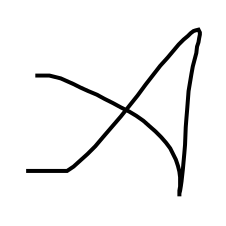

In [9]:
d = document(80, 80, 'mm')
page = d.addpage()
figure = shape().stroke(rgba(0, 0, 0, 255)).width(4)
form = choice(chars["A"])
for stroke in form:
    line = Polyline(stroke).scale(0.25).translate(40, 40)
    page.place(figure.polyline(line))
show(page)

## Draw a character with a simulated brushstroke

Using the `.fancy_curve()` method of Bezmerizing's `Polyline` class, we can create a polygon that follows the normals of a Catmull-Rom spline, offset at distances specified by a list of thicknesses (which is interpolated to the length of the curve). This makes a simulated brushstroke:

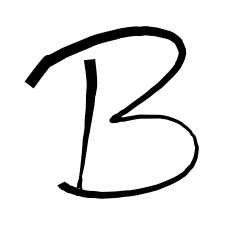

In [10]:
d = document(80, 80, 'mm')
page = d.addpage()
figure = shape().nostroke().fill(rgba(0, 0, 0, 255))
form = choice(chars["B"])
for stroke in form:
    line = Polyline(stroke).augment().scale(0.2).translate(40, 40)
    curve = line.fancy_curve(samples_per=24, thicknesses=[4, 2, 1, 3], tightness=-0.5)
    lines = figure.polygon(curve)
    page.place(lines)
show(page)

### Draw a grid

The following example draws random brush-stroked letters on a grid:

In [11]:
width = 80
height = 80
d = document(width, height, 'mm')
page = d.addpage()
brush = shape().fill(rgba(40, 40, 240, 240)).nostroke()
grid_size = 9
# size of a single rectangle in the grid
cell_size_x = width / grid_size
cell_size_y = height / grid_size
for i in range(grid_size):
    for j in range(grid_size):
        x = i * cell_size_x + (cell_size_x * 0.5) # add 1/2 cell size to offset glyph center
        y = j * cell_size_y + (cell_size_y * 0.5)
        # pick a random letter
        let = choice(list(chars.keys()))
        # pick a random example of that letter
        glyph = choice(chars[let])
        for stroke in glyph:
            pline = Polyline(stroke).scale(0.025).translate(x, y)
            curve = pline.augment().fancy_curve(samples_per=12, thicknesses=[0, 2, 1, 1, 0])
            page.place(brush.polygon(curve))
show(page)

## Remixing letters

Let's do a few experiments using this data to generate new forms. I'm going to do two cut-ups. The first creates new letters by remixing strokes from all available characters. The second cuts letters in half and recombines the two halves.

### Letters from random strokes

First, I'm going to make a big list of all of the strokes that occur in *any* character in the dataset. The `.values()` method of the `chars` dictionary has a list of lists of characters. To flatten this to a single list, I use the [`chain` function from `itertools` package](https://docs.python.org/3/library/itertools.html#itertools.chain). ([Good Stack Overflow thread on flattening lists of lists in Python](https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists#45323085).)

In [12]:
from itertools import chain

In [13]:
all_forms = list(chain(*chars.values()))

Now `all_forms` is a list of all characters in the dataset (regardless of which letter they draw).

In [14]:
len(all_forms)

3410

To get a list of strokes, we need to flatten this list too:

In [15]:
all_strokes = list(chain(*all_forms))

... which gives us around 5k strokes:

In [16]:
len(all_strokes)

5034

The following cell grabs a stroke at random and draws it: 

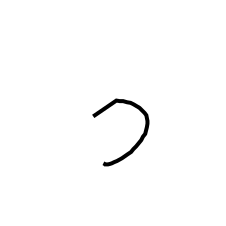

In [17]:
d = document(80, 80, 'mm')
page = d.addpage()
figure = shape().stroke(rgba(0, 0, 0, 255)).width(4)
stroke = choice(all_strokes)
line = Polyline(stroke).scale(0.2).translate(40, 40)
page.place(figure.polyline(line))
show(page)

Now we can generate new characters from the stroke data. The following function generates a new character by sampling the list of strokes, returning a list of Polylines:

In [18]:
import random
def make_char():
    char = [Polyline(s) for s in random.sample(all_strokes, choice([2, 3, 4]))]
    return char

This code shows one character generated with this function. (Run it multiple times to see a bunch of different outputs.)

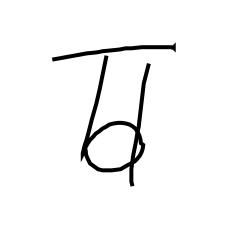

In [19]:
d = document(80, 80, 'mm')
page = d.addpage()
figure = shape().stroke(rgba(0, 0, 0, 255)).width(4)
random_strokes = make_char()
for pline in random_strokes:
    pline = pline.scale(0.2).translate(40, 40)
    lines = figure.polyline(pline)
    page.place(lines)
show(page)

Finally, here's a grid of characters generated in this fashion, with a little bit of added randomness in how the strokes are scaled and rotated:

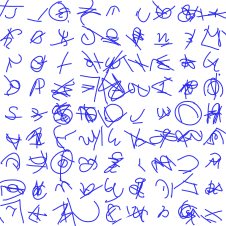

In [20]:
width = 80
height = 80
d = document(width, height, 'mm')
page = d.addpage()
brush = shape().stroke(rgba(40, 40, 240, 240)).nofill()
grid_size = 9
# size of a single rectangle in the grid
cell_size_x = width / grid_size
cell_size_y = height / grid_size
for i in range(grid_size):
    for j in range(grid_size):
        x = i * cell_size_x + (cell_size_x * 0.5) # add 1/2 cell size to offset glyph center
        y = j * cell_size_y + (cell_size_y * 0.5)
        glyph = make_char()
        for pline in glyph:
            pline = pline.rotate(uniform(2*np.pi)).scale(normal(0.025, 0.001)).translate(x, y)
            page.place(brush.polyline(pline))
show(page)

> Exercise idea: Experiment with appending these polylines together, instead of superimposing them. Can you create cursive-looking letterforms, for example?

### Half-letters

Here's another quick example that algorithmically modifies the handwriting data in order to create new forms. In this case, I wrote a function below that selects two letterforms at random—one for the left side of the generated glyph, and one for the right side of the generated glyph. The function makes a list of polylines from every point that is either less than zero (for the left-hand letterform) or greater than zero (for the right-hand letterform). (Remember that the handwriting data has been normalized so that the center of the letterform is at `0, 0`.) The function then combines and returns these two lists of polylines.

In [21]:
def make_halfsies():
    left = choice(all_forms)
    right = choice(all_forms)
    left_strokes = []
    right_strokes = []
    for stroke in left:
        pts = []
        for pt in stroke:
            # nb. pt[0] is the x coordinate of this point
            if pt[0] < 0:
                pts.append(pt)
        if len(pts) > 1:
            left_strokes.append(Polyline(pts))
    for stroke in right:
        pts = []
        for pt in stroke:
            if pt[0] > 0: 
                pts.append(pt)
        if len(pts) > 1:
            right_strokes.append(Polyline(pts))
    # concatenate lists and return
    return left_strokes + right_strokes

This example shows one glyph generated with this technique. (Run it a bunch of times to see different results.)

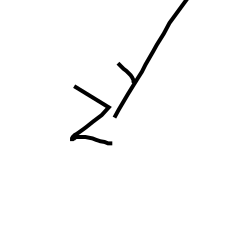

In [22]:
d = document(80, 80, 'mm')
page = d.addpage()
figure = shape().stroke(rgba(0, 0, 0, 255)).width(4)
for pline in make_halfsies():
    pline = pline.scale(0.25).translate(40, 40)
    lines = figure.polyline(pline)
    page.place(lines)
show(page)

The example code in the following cell gets a bit fancy, drawing each of these polyline strokes with the `.fancy_curve()` method in a grid:

In [23]:
width = 150
height = 150
d = document(width, height, 'mm')
page = d.addpage()
brush = shape().nostroke().fill(rgba(40, 40, 40, 220))
grid_size = 9
# size of a single rectangle in the grid
cell_size_x = width / grid_size
cell_size_y = height / grid_size
for i in range(grid_size):
    for j in range(grid_size):
        x = i * cell_size_x + (cell_size_x * 0.5) # add 1/2 cell size to offset glyph center
        y = j * cell_size_y + (cell_size_y * 0.5)
        glyph = make_halfsies()
        for pline in glyph:
            pline = pline.augment().scale(0.05).translate(x, y)
            curve = pline.fancy_curve(samples_per=12, thicknesses=[0.5, 3, 2, 1, 0.5, 0])
            page.place(brush.polygon(curve))
            pline = pline.rotate(uniform(2*np.pi)).scale(normal(0.025, 0.001)).translate(x, y)
            page.place(brush.polyline(pline))
show(page)